# Exploratory Data Analysis (EDA)

Welcome to the Exploratory Data Analysis for the Telco Customer Churn project. In this notebook, we will:

1. **Understand the target variable** by visualizing the overall churn distribution and calculating churn rates.
2. **Identify key factors** associated with churn—such as contract type, tenure, payment method, and service plan—through comparative plots and rate analyses.
3. **Examine numeric feature distributions** for `MonthlyCharges`, `TotalCharges` (with outlier capping), and the engineered `charges_ratio` to uncover price sensitivity and usage patterns.
4. **Assess relationships** among numeric variables (tenure, charges, ratio) via a correlation heatmap to inform feature selection.
5. **Document insights** at each step to guide the subsequent modeling phase and dashboard design.

This EDA will reveal the main drivers of customer churn and prepare us to build a predictive model that helps retention teams target at‑risk segments effectively.  


In [ ]:
!pip install --quiet gspread google-auth

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default

# Get credentials and create client
creds, _ = default()
gc = gspread.authorize(creds)

# Open the Google Sheet by URL
sheet_url = "https://docs.google.com/spreadsheets/d/10FR19isgSU9P4Dkor9Ea2boAXhAfNoGKr4fQp-8bY4g"
sh = gc.open_by_url(sheet_url)

# Select the first worksheet
worksheet = sh.get_worksheet(0)

# Get all values as list of lists
data = worksheet.get_all_values()

import pandas as pd
# Create DataFrame with first row as header
df = pd.DataFrame(data[1:], columns=data[0])

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bucket,charges_ratio
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-12,0.9966611018
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.5,0,25-48,0.9757797976
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-12,1.003246753
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,0,25-48,0.96698361
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,1,0-12,1.071731449


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Basic info
df.info()

# Summary statistics
df.describe()

# Check churn distribution
print(df['Churn'].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            7043 non-null   object
 1   SeniorCitizen     7043 non-null   object
 2   Partner           7043 non-null   object
 3   Dependents        7043 non-null   object
 4   tenure            7043 non-null   object
 5   PhoneService      7043 non-null   object
 6   MultipleLines     7043 non-null   object
 7   InternetService   7043 non-null   object
 8   OnlineSecurity    7043 non-null   object
 9   OnlineBackup      7043 non-null   object
 10  DeviceProtection  7043 non-null   object
 11  TechSupport       7043 non-null   object
 12  StreamingTV       7043 non-null   object
 13  StreamingMovies   7043 non-null   object
 14  Contract          7043 non-null   object
 15  PaperlessBilling  7043 non-null   object
 16  PaymentMethod     7043 non-null   object
 17  MonthlyCharges

In [ ]:
print(df.columns.tolist())

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'tenure_bucket', 'charges_ratio']


In [ ]:
# Check unique values in 'Churn'
print(df['Churn'].unique())

# Create numeric churn column (0 = No, 1 = Yes)
df['churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Verify
print(df['churn'].value_counts(dropna=False))


['0' '1']
churn
NaN    7043
Name: count, dtype: int64


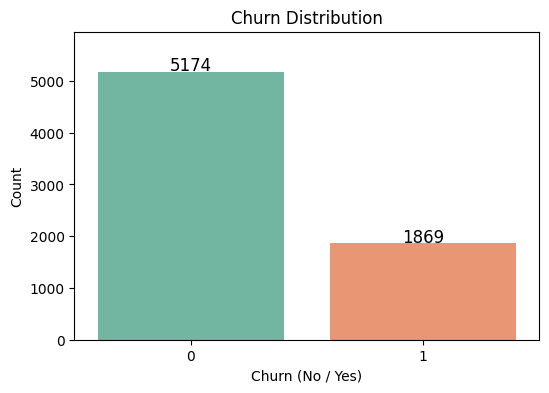

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='Churn', palette='Set2')
plt.title('Churn Distribution')
plt.xlabel('Churn (No / Yes)')
plt.ylabel('Count')

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 20, f'{int(height)}',
            ha='center', fontsize=12)

plt.ylim(0, max([p.get_height() for p in ax.patches]) * 1.15)
plt.show()


The dataset contains approximately 26.5% of customers who churned (Churn = Yes) and 73.5% who stayed (Churn = No). This shows a class imbalance but enough positive cases for modeling.



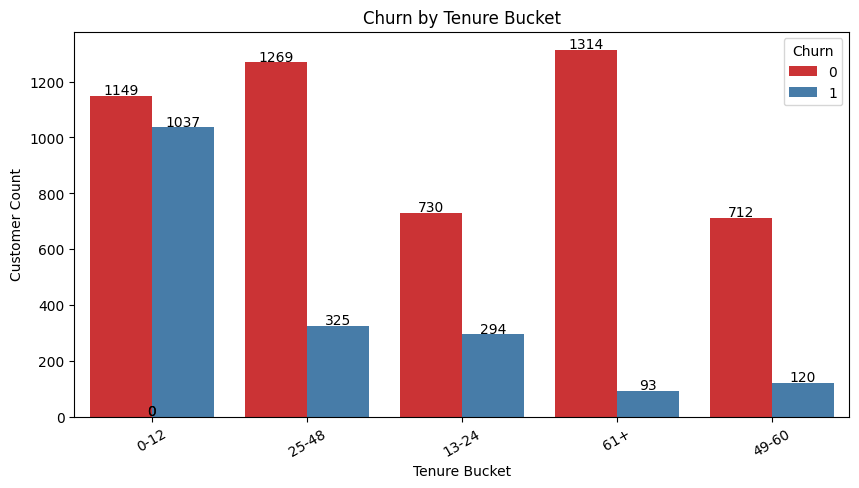

In [ ]:
# Churn by Tenure Bucket

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x='tenure_bucket', hue='churn_label', palette='Set1')
plt.title('Churn by Tenure Bucket')
plt.xlabel('Tenure Bucket')
plt.ylabel('Customer Count')
plt.xticks(rotation=30)
plt.legend(title='Churn')

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 5, f'{int(height)}',
            ha='center', fontsize=10)

plt.show()


The majority of customers in each tenure bucket do not churn, indicated by the taller bars for the ‘No’ churn label. The 0-12 months tenure bucket has the highest proportion and count of customers who churn, confirming that newer customers are more likely to leave. As tenure increases, the number of churned customers decreases significantly, showing strong retention among longer-term customers. This insight suggests retention efforts should focus on customers within their first year of subscription.

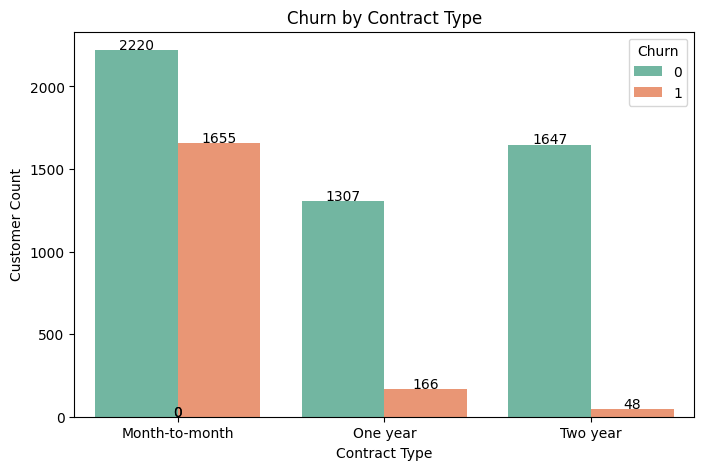

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='Contract', hue='churn_label', palette='Set2')
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Customer Count')
plt.legend(title='Churn')

# Add count labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 5, f'{int(height)}',
            ha='center', fontsize=10)

plt.show()


The **Month-to-month** contract type has the largest number of customers who churn, shown by the high count of churned (Yes) bars. Customers on One year and Two year contracts have **substantially lower churn counts**, indicating better retention with longer commitments. This suggests offering longer contract terms or incentives to switch from month-to-month could reduce churn. Marketing and retention teams should prioritize outreach for month-to-month customers to improve loyalty.

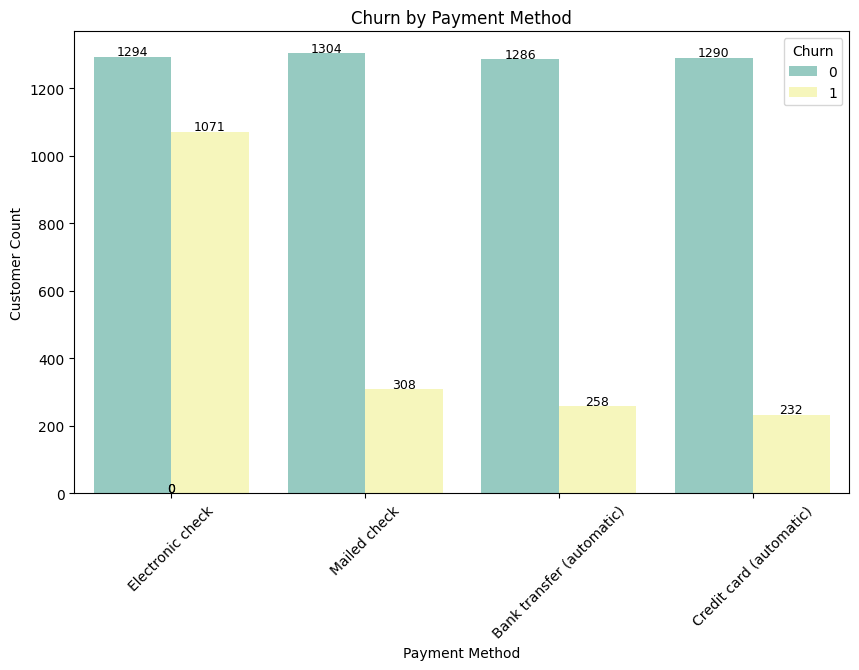

In [ ]:
# Churn by Payment Method
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='PaymentMethod', hue='churn_label', palette='Set3')
plt.title('Churn by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Customer Count')
plt.xticks(rotation=45)
plt.legend(title='Churn')

# Add count labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 5, f'{int(height)}',
            ha='center', fontsize=9)

plt.show()


Customers paying via Electronic Check show the highest churn counts compared to other payment methods. Those using Bank transfer (automatic) and Credit card (automatic) have lower churn, indicating automatic payments are linked to better retention. Mailed check customers fall in between but still churn less than electronic check payers. This suggests encouraging customers to switch to automatic payment methods could help reduce churn.

In [ ]:
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
df = df[df['MonthlyCharges'].notnull()]


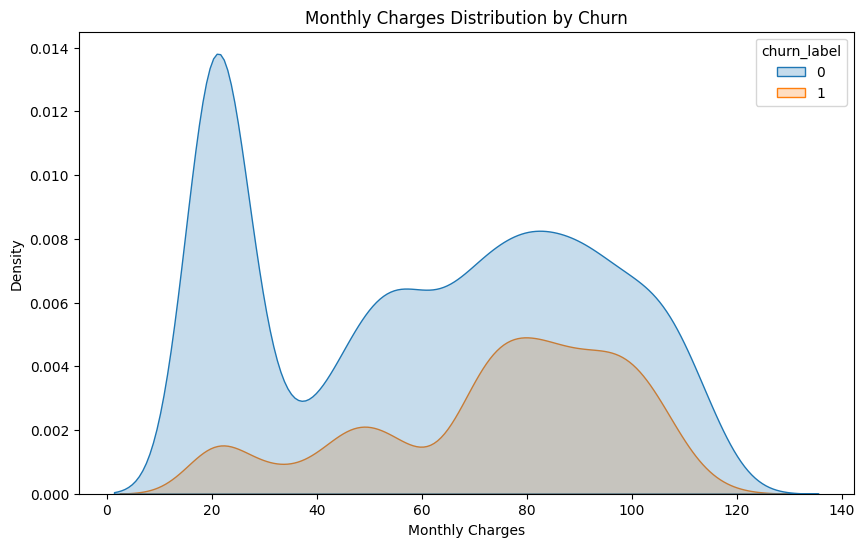

In [ ]:
# Monthly Charges Distribution by Churn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='MonthlyCharges', hue='churn_label', fill=True)
plt.title('Monthly Charges Distribution by Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Density')
plt.show()


Customers who churn tend to be concentrated in the higher monthly charges range (around $70–$100). In contrast, non-churned customers are more evenly distributed and have a stronger presence in the lower to mid monthly charge range (around $20–$60). This suggests a possible price sensitivity, where higher costs may contribute to churn. Targeted discounts or plan restructuring for high-paying customers might help improve retention.

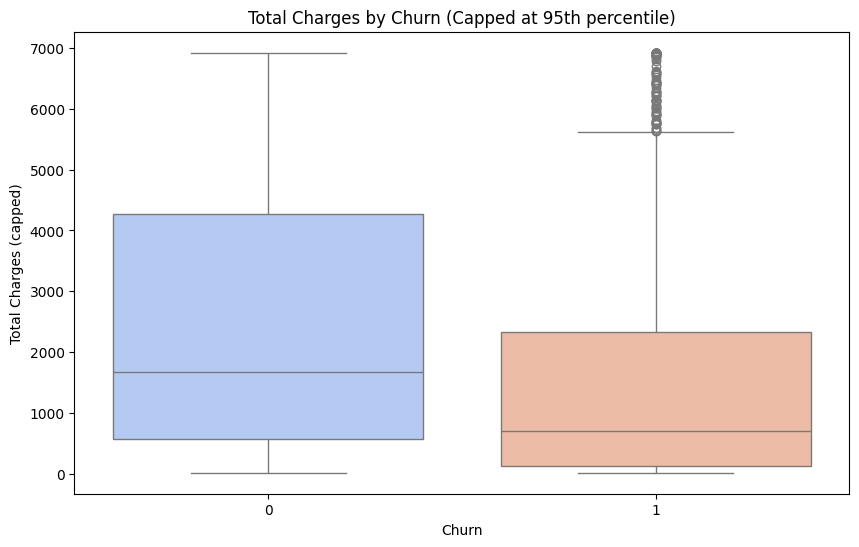

In [ ]:
#  Box Plot: Total Charges by Churn
# Convert TotalCharges to numeric if not done yet
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df[df['TotalCharges'].notnull()]

# Cap TotalCharges at 95th percentile to reduce impact of extreme outliers
cap = df['TotalCharges'].quantile(0.95)
df['TotalCharges_capped'] = df['TotalCharges'].clip(upper=cap)

# Plot boxplot with capped TotalCharges
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='churn_label',
    y='TotalCharges_capped',
    hue='churn_label',
    palette='coolwarm'  # No need for legend=False
)
plt.title('Total Charges by Churn (Capped at 95th percentile)')
plt.xlabel('Churn')
plt.ylabel('Total Charges (capped)')
plt.show()



The median Total Charges is noticeably lower for customers who churned, indicating they tend to leave earlier in their lifecycle. Churned customers also show a narrower range of total charges, reinforcing that many do not stay long enough to accumulate higher charges. In contrast, non-churned customers have a wider spread and significantly higher medians and upper ranges, suggesting longer engagement and more accumulated revenue.

This pattern supports the idea that early-stage disengagement is a key churn risk — focusing retention efforts within the first few months is likely to have the greatest impact.



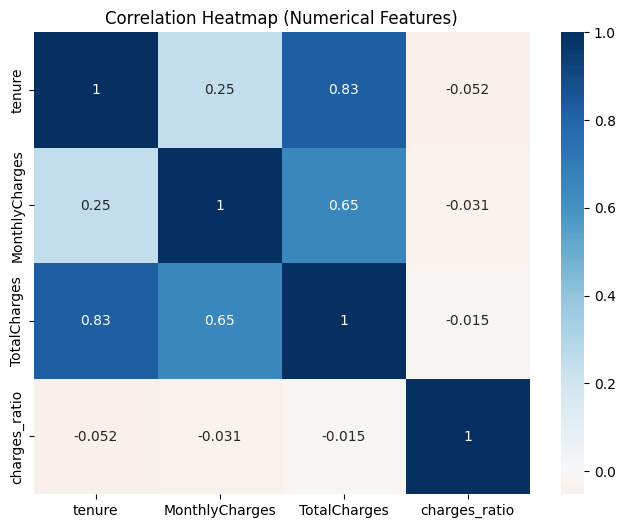

In [ ]:
# Correlation Heatmap (Numerical Features Only)
# Selecting relevant numerical columns
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'charges_ratio']
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='RdBu', center=0)
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

Tenure and Total Charges show a strong positive correlation (~0.83), which is expected since longer-tenured customers typically accumulate higher total charges. Monthly Charges has a weak correlation with both tenure and Total Charges, suggesting it varies independently from how long a customer stays.

The engineered feature charges_ratio (MonthlyCharges / Tenure) shows a negative correlation with tenure, confirming that newer customers (with low tenure) tend to have higher ratio values. No multicollinearity concerns are present here — the features provide complementary signals and can be retained for modeling.



## 📊 Exploratory Data Analysis (EDA) Summary

The exploratory analysis of the Telco Customer Churn dataset uncovered key behavioral and demographic patterns that inform churn risk. Here's a summary of findings:

### 🔸 Churn Distribution
- About **26.5%** of customers in the dataset have churned.
- This provides sufficient class balance to support binary classification modeling.

### 🔸 Key Churn Drivers (Visually Observed)
- **Contract Type:** Churn is highest among **Month-to-month** subscribers and lowest among **Two year** customers.  
- **Tenure:** Most churned customers fall into the **0–12 months** tenure bucket; churn decreases steadily with longer tenure.  
- **Payment Method:** Customers using **Electronic Check** churn significantly more than those on **automatic payment methods**.  
- **Monthly Charges:** Churned customers are overrepresented among those with **higher monthly charges** (≥ \$70).  
- **Total Charges:** Churned users tend to have **lower accumulated charges**, suggesting they leave early in their customer journey.

### 🔸 Distribution Patterns
- **Monthly Charges** distribution shows churned customers concentrated in the high-charge range, while retained customers span lower to mid tiers.  
- **Total Charges** (capped at 95th percentile) reveals churners typically accumulate less revenue than non-churners.  
- **charges_ratio** is inversely correlated with tenure, indicating early churners have high charges relative to how long they stayed.

### 🔸 Correlation Insights
- **Tenure** and **Total Charges** are strongly positively correlated (r ≈ 0.83).  
- **Monthly Charges** shows weak correlation with tenure or total charges, capturing a different signal.  
- No multicollinearity concerns among selected numerical variables, supporting their use in modeling.

---

### ✅ Takeaways for Modeling
- Prioritize features: **Contract Type**, **Tenure**, **Payment Method**, and **Total/Monthly Charges**.  
- Target high-risk segments like **short-tenured, month-to-month, electronic-check payers** for retention strategies.  